### Clustering progressive passes

In this tutorial we show how to cluster progressive passes using KMeans clustering.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import os
import pathlib
import json
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

Let's open the WyScout data at first

In [2]:
file_name = 'events_England.json'
path = os.path.join(str(pathlib.Path().resolve()[0]), 'data', file_name)
with open(path) as f:
    df = pd.DataFrame(json.load(f))

**Preparing the dataset**

First we take the matchId of the game we want to analyze. Then, we filter out passes which ended in (0, 68) or (105, 0) as well as ones that ended out of the pitch. Clustering progressive passes can be also done for on player and the entire season

In [3]:
#get events from match
match_id = 2500045

match_events = df.loc[df["matchId"] == match_id]
next_event = match_events.shift(-1, fill_value=0)
match_events["nextEvent"] = next_event["subEventName"]
match_events['player_rec'] = next_event["playerId"]
match_events["kickedOut"] = match_events.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

passes = match_events[match_events.eventName=='Pass']
passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

passes = passes[passes.kickedOut!=1]
passes = passes[(((passes["end_x"] != 0) & (passes["end_y"] != 68)) & ((passes["end_x"] != 105) & (passes["end_y"] != 0)))]

passes.shape[0]

831

Let's look for and retrieve just progressive passes.

According to WyScout, a pass is considered progressive if the distance between the starting point and the next touch is:

    - at least 30 meters closer to the opponent’s goal if the starting and finishing points are within a team’s own half
    - at least 15 meters closer to the opponent’s goal if the starting and finishing points are in different halves
    - at least 10 meters closer to the opponent’s goal if the starting and finishing points are in the opponent’s half

Also, we keep only passes made by Manchester United.

In [4]:
def is_progressive(x, y, end_x, end_y, top_x):
    start_dist = np.sqrt((105 - x)**2 + (34 - y)**2) #dist from goal of the starting point
    end_dist = np.sqrt((105 - end_x)**2 + (34 - end_y)**2) # dist from goal of the ending point
    #mark that passes to own half are not progressive
    thres = 100
    if x < top_x/2 and end_x < top_x/2:
        thres = 30
    elif x < top_x/2 and end_x >= top_x/2: # parte de campo propio y acaba en campo rival
        thres = 15
    elif x >= top_x/2 and end_x >= top_x/2: # siempre en campo rival
        thres = 10
    if (start_dist - end_dist) < thres:
        return False
    else:
        return True
    
passes['prog'] = passes.apply(lambda x: is_progressive(x['x'], x['y'], x['end_x'], x['end_y'], 105),axis=1)
united_passes = passes.loc[passes["teamId"] != 1625]
united_progressive = united_passes.loc[united_passes["prog"] == True]

united_progressive["angle"] = np.arctan2(united_progressive["end_y"] - united_progressive["y"], united_progressive["end_x"] - united_progressive["x"])

### Finding out optimal number of clusters

To find the optimal number of clusters we use the elbow method - comparision between SSE score and number of clusters. Optimal number of clusters should be determined by an elbow. In our case the elbow is for k = 5. You can try crustering using different k values as well as different clustering algorithms

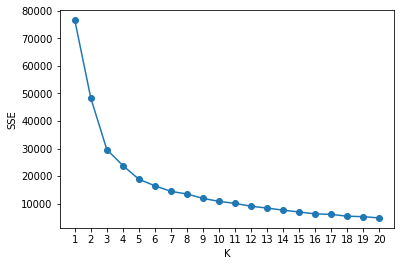

Text(0.5, 0, 'k')

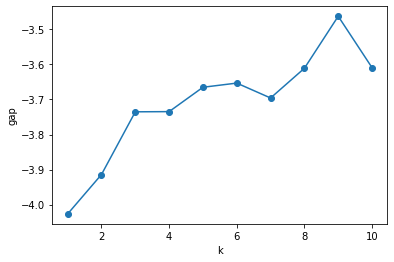

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

K = np.linspace(1, 20, 20)
X = united_progressive[["x", "y", "end_x", "end_y", "angle"]].values
elbow = {"sse": [], "k": [], "sil": []}

for k in K:
    cluster = KMeans(n_clusters = int(k), random_state = 2147)
    labels = cluster.fit_predict(X)
    elbow["sse"].append(cluster.inertia_)
    elbow["k"].append(k)
    
plt.scatter(elbow["k"], elbow["sse"])
plt.plot(elbow["k"], elbow["sse"])
plt.xticks(np.linspace(1, 20, 20))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()

def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))

    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))

    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 10
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(random_state = 2147), X, k_max)

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

### Clustering Passes

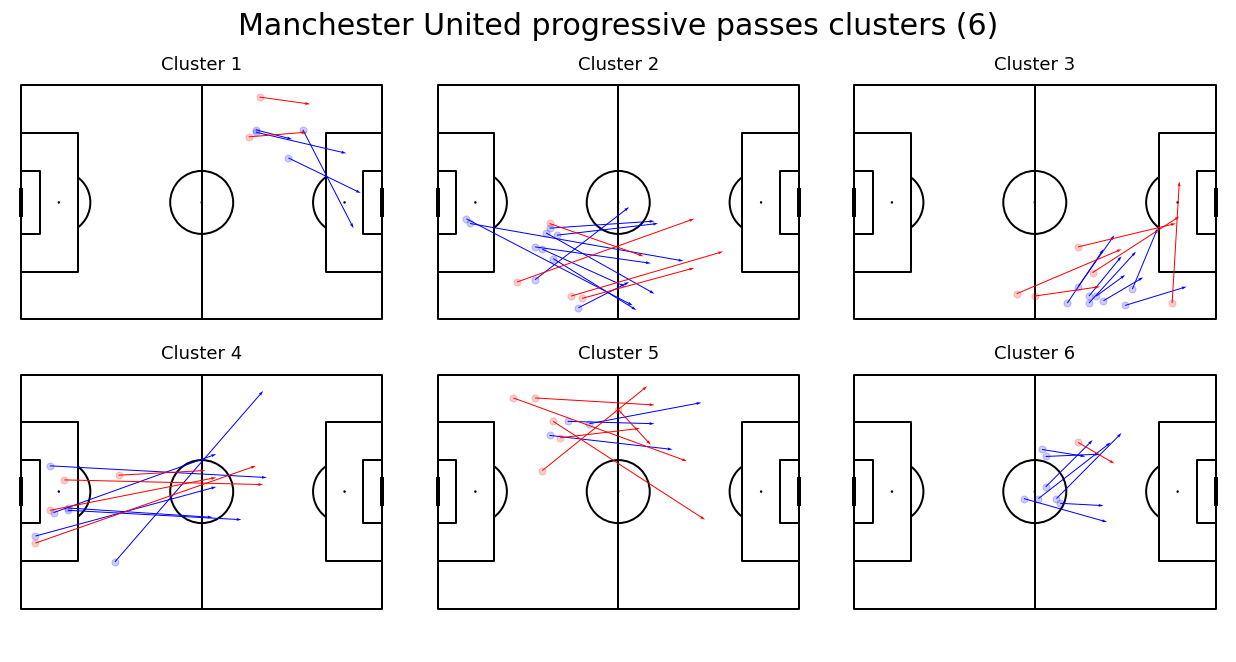

In [6]:
k = 6

cluster = KMeans(n_clusters = int(k), random_state = 2147)
labels = cluster.fit_predict(X)

united_progressive["label"] = labels

pitch = Pitch(line_color='black', pitch_type = "custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(ncols = 3, nrows = 2, grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)

for clust, ax in zip(np.linspace(0, k-1, k), axs['pitch'].flat[:k]):
    ax.text(52.5, 74, "Cluster " + str(int(clust+1)),
            ha='center', va='center', fontsize=18)
    clustered = united_progressive.loc[united_progressive["label"] == clust]
    acc = clustered.loc[clustered.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    inacc = clustered.loc[clustered.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
    
    pitch.scatter(acc.x, acc.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
    pitch.arrows(acc.x, acc.y,
            acc.end_x, acc.end_y, color = "blue", ax=ax, width=1)
    pitch.scatter(inacc.x, inacc.y, alpha = 0.2, s = 50, color = "red", ax=ax)
    #plot arrow
    pitch.arrows(inacc.x, inacc.y,
            inacc.end_x, inacc.end_y, color = "red", ax=ax, width=1)
    
axs['title'].text(0.5, 0.5, 'Manchester United progressive passes clusters ({})'.format(int(k)), ha='center', va='center', fontsize=30)
plt.show()

In [7]:
file_players = 'players.json'
path_players = os.path.join(str(pathlib.Path().resolve()), 'data', file_players)
with open(path_players) as f:
    players = pd.DataFrame(json.load(f))

In [22]:
players_mu = players[players.currentTeamId==passes.teamId.values[0]]
id_pl = players_mu[players_mu.shortName.str.contains('P. Pogba')].wyId.values[0]
print(id_pl,'-',players_mu[players_mu.wyId==id_pl].shortName.values[0])

7936 - P. Pogba


In [9]:
from yellowbrick.cluster.elbow import kelbow_visualizer
def elbow_method(X, max_range_for_elbow):
    return kelbow_visualizer(KMeans(random_state=0), X, k=(1, max_range_for_elbow))

In [139]:
united_passes["angle"] = np.arctan2(united_passes["end_y"] - united_passes["y"], united_passes["end_x"]- united_passes["x"])
passes_pl = united_passes[united_passes.player_rec==id_pl]
print(passes_pl.shape[0])

passes_pl['start_dist'] = np.sqrt((105 - passes_pl.x)**2 + (34 - passes_pl.y)**2) #dist from goal of the starting point
passes_pl['end_dist'] = np.sqrt((105 - passes_pl.end_x)**2 + (34 - passes_pl.end_y)**2) # dist from goal of the ending point
passes_pl['dist'] = abs(passes_pl['end_dist'] - passes_pl['start_dist'])

X = passes_pl[["x", "y", "end_x", "end_y", "dist", "angle"]].values

19


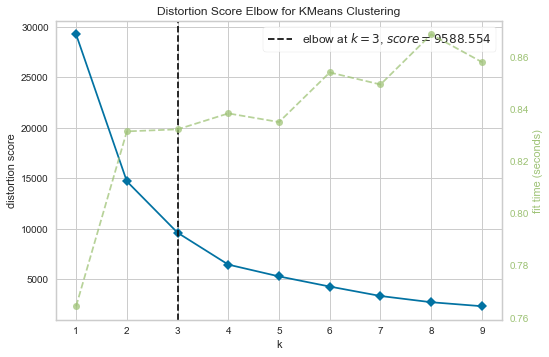

In [140]:
elb = elbow_method(X,10)

In [141]:
k = elb.elbow_value_

cluster = KMeans(n_clusters = int(k), random_state = 2147)
labels = cluster.fit_predict(X)

passes_pl['cluster'] = labels

In [142]:
passes_pl['color'] = passes_pl.cluster.apply(lambda x: plt.cm.rainbow(np.linspace(0, 1, 3)[x]))

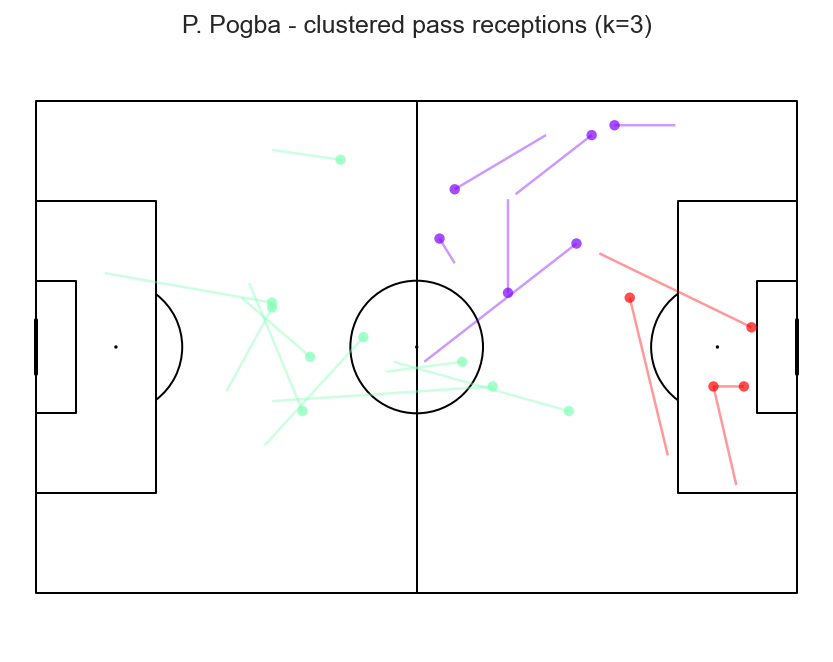

In [144]:
pitch = Pitch(line_color='black', pitch_type = "custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)

pitch.lines(passes_pl.x, passes_pl.y,passes_pl.end_x, passes_pl.end_y,alpha=0.4,color=passes_pl['color'],
           ax=axs['pitch'],lw=2.5)
pitch.scatter(passes_pl.end_x, passes_pl.end_y, alpha = 0.7, s = 100, c = passes_pl['color'], ax=axs['pitch'])
axs['title'].text(0.5, 0.5, '{} - clustered pass receptions (k={})'.format(players_mu[players_mu.wyId==id_pl].shortName.values[0],int(k)), ha='center', va='center', fontsize=25)
plt.show();